In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet.gluon import data as gdata
import sys
import time

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True)
mnist_test = gdata.vision.FashionMNIST(train=False)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
feature, label = mnist_train[0]

In [5]:
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

In [6]:
label, label.dtype

(2, dtype('int32'))

In [7]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [8]:
help(d2l.plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, optional, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (`sharex`) or y (`sharey`)
        axes:
    
            - True or 'all': x- or y-axis will be shared among all
              subplots.
            - False or 'none': each subplot x- or y-axis will be
              independent.
            - 'row': each subplot row will share an x- or y-axis.
            - 'col': each subplot column will share an x- or y-axis.
    
        Wh

In [9]:
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    _, figs = d2l.plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape(28, 28).asnumpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

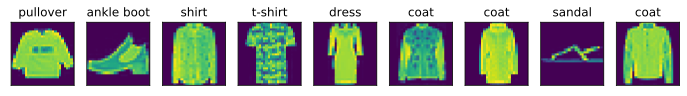

In [10]:
X, y = mnist_train[0:9]  # 获取前十条数据
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [11]:
batch_size = 256
# 切换通道在前
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = gdata.DataLoader(mnist_train.transform_first(transformer), 
                              batch_size, shuffle=True, num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
                             batch_size, shuffle=True, num_workers=num_workers)

In [12]:
start = time.time()
for X, y in train_iter:
    continue
'%.2f sec' % (time.time() - start)

'2.59 sec'

### SOftMax回归

In [13]:
from mxnet import autograd, nd

In [14]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [15]:
num_inputs = 784
num_outputs = 10

w = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

In [16]:
# 附上梯度
w.attach_grad()
b.attach_grad()

In [17]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition

In [18]:
X = nd.random.normal(scale=0.01, shape=(2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(axis=1)

(
 [[ 0.00608782  0.01074176  0.00066428  0.00848699 -0.0080038 ]
  [-0.00168822  0.00936328  0.00357444  0.00779328 -0.01010307]]
 <NDArray 2x5 @cpu(0)>,
 
 [[0.20049462 0.20142987 0.19941017 0.20097621 0.19768913]
  [0.19930099 0.2015158  0.20035261 0.20119965 0.19763094]]
 <NDArray 2x5 @cpu(0)>,
 
 [1. 1.]
 <NDArray 2 @cpu(0)>)

In [19]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), w) + b)

In [20]:
# 使用pick()函数
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [21]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

In [22]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [23]:
accuracy(y_hat, y)

0.5

In [26]:
# 计算模型net在data_itersahng
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y.astype('float32')).sum().asscalar()
        n += y.size
    return acc_sum / n

In [27]:
evaluate_accuracy(test_iter, net)

0.0925

In [35]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, 
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print("epoch %d, loss %.4f, train_acc %.3f, test_acc %.3f" 
              %(epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size,
         [w, b], lr)

epoch 1, loss 0.4783, train_acc 0.837, test_acc 0.842
epoch 2, loss 0.4689, train_acc 0.841, test_acc 0.843
epoch 3, loss 0.4624, train_acc 0.842, test_acc 0.846
epoch 4, loss 0.4575, train_acc 0.845, test_acc 0.845
epoch 5, loss 0.4504, train_acc 0.846, test_acc 0.849


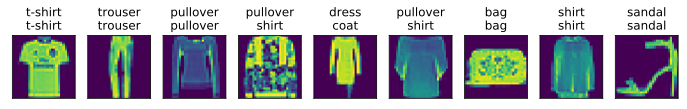

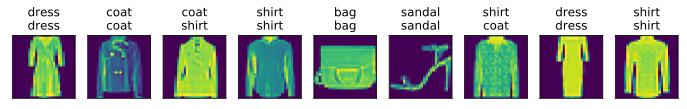

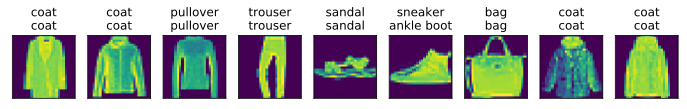

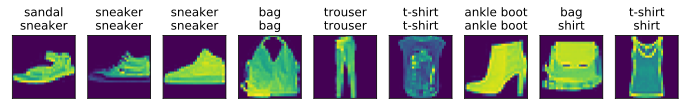

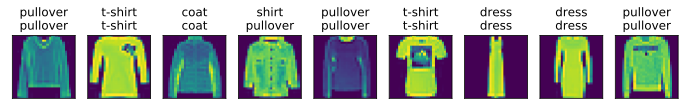

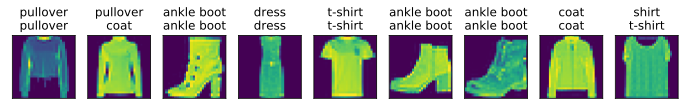

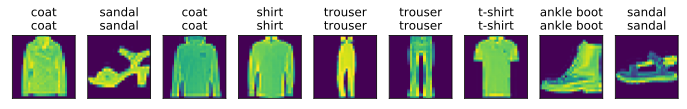

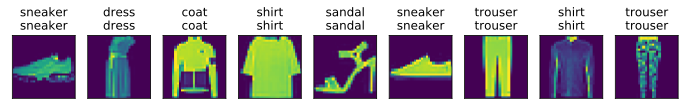

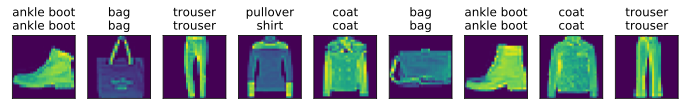

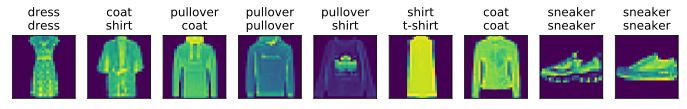

In [48]:
for X, y in test_iter:
    break
    
true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

for i in range(10):
    d2l.show_fashion_mnist(X[i * 10:i * 10 + 9], titles[i * 10:i * 10 + 9])

In [37]:
help(d2l.get_fashion_mnist_labels)

Help on function get_fashion_mnist_labels in module d2lzh.utils:

get_fashion_mnist_labels(labels)
    Get text label for fashion mnist.



### 简洁实现

In [49]:
%matplotlib inline
from mxnet import gluon, init
from mxnet.gluon import loss as gloss, nn

In [50]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [51]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [52]:
loss = gloss.SoftmaxCrossEntropyLoss()

In [60]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.01})

In [62]:
num_epochs = 15
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 0.4709, train acc 0.841, test acc 0.843
epoch 2, loss 0.4698, train acc 0.842, test acc 0.843
epoch 3, loss 0.4690, train acc 0.842, test acc 0.845
epoch 4, loss 0.4681, train acc 0.843, test acc 0.844
epoch 5, loss 0.4672, train acc 0.843, test acc 0.844
epoch 6, loss 0.4664, train acc 0.843, test acc 0.844
epoch 7, loss 0.4655, train acc 0.843, test acc 0.845
epoch 8, loss 0.4648, train acc 0.844, test acc 0.845
epoch 9, loss 0.4639, train acc 0.844, test acc 0.846
epoch 10, loss 0.4631, train acc 0.844, test acc 0.846
epoch 11, loss 0.4623, train acc 0.844, test acc 0.846
epoch 12, loss 0.4617, train acc 0.844, test acc 0.846
epoch 13, loss 0.4610, train acc 0.845, test acc 0.845
epoch 14, loss 0.4602, train acc 0.845, test acc 0.846
epoch 15, loss 0.4595, train acc 0.845, test acc 0.846


In [59]:
help(d2l.train_ch3)

Help on function train_ch3 in module d2lzh.utils:

train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None)
    Train and evaluate a model with CPU.



In [ ]:
3